In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

videofile = './Novgorod_2019-04-05-15_15_00.mp4'

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)
k = 10

In [13]:
def get_background(filename, k, iters=10):
    cap = cv2.VideoCapture(filename)
    _, frame_1 = cap.read()
    frame_1 = cv2.resize(frame_1, dsize=tuple(np.array(frame_1.shape[:2][::-1])//k))
    background = frame_1
    for _ in range(iters-1):
        ret, frame_2 = cap.read()
        frame_2 = cv2.resize(frame_2, dsize=tuple(np.array(frame_2.shape[:2][::-1])//k))
        if not ret:
            return background
        
        background = np.where(frame_1 == frame_2, frame_1, background)
        frame_1 = frame_2

    cap.release()
    return background

In [9]:
from keras.models import load_model

clf = load_model('car_clf6.model')
classes = ['motorcycle',
 'pickup_truck',
 'car',
 'work_van',
 'articulated_truck',
 'single_unit_truck',
 'bus']

In [10]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)

def detect_vehicles(fg_mask, size_thres):

    saved_masks = list()
    centers = list()
    bbox = list()

    # finding masks
    labels_cnt, masks = cv2.connectedComponents(threshed)
    labels, cnt = np.unique(masks, return_counts=True)

    # filtering by width, height
    for i in range(labels_cnt):
        if cnt[i] < size_thres:
            continue
        mask = (masks==i).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(mask)
        tmp_xywh = np.array([x,y,w,h], dtype=np.float16)
        tmp_xywh[2:4] += tmp_xywh[0:2]
        tmp_xywh = list(tmp_xywh)
        tmp_xywh += [1]
        bbox.append(tmp_xywh)
        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)
        saved_masks.append(mask)
        centers.append(centroid)
    return saved_masks, centers, bbox


In [11]:
def square_resize(frame_orig, tracker, k):
    h = np.abs(tracker[1]*k - tracker[3]*k)
    w = np.abs(tracker[0]*k - tracker[2]*k)
    
    expand_half = np.abs(w-h)//2
    if w>h:
        return frame_orig[tracker[1]*k-expand_half:tracker[3]*k+expand_half, tracker[0]*k:tracker[2]*k]
    else:
        return frame_orig[tracker[1]*k:tracker[3]*k, tracker[0]*k-expand_half:tracker[2]*k+expand_half]

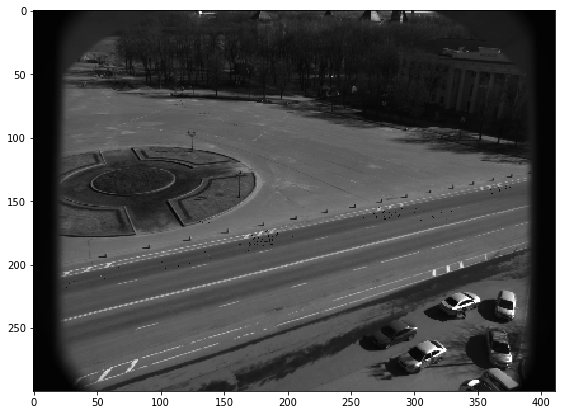

In [14]:
bg = get_background(videofile, k, 70)
plt.imshow(bg)
bg = bg[:,:,0]

In [85]:
import traceback
from sys import exc_info
from time import sleep
import time
from sort.sort import Sort

out = cv2.VideoWriter('final.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (411, 300))

size_thres = 200
frame_time = []
mot_tracker = Sort()
classes_distr = {
    classes[0]: 0,
    classes[1]: 0,
    classes[2]: 0,
    classes[3]: 0,
    classes[4]: 0,
    classes[5]: 0,
    classes[6]: 0,
}
classes_pict = {
    classes[0]: [],
    classes[1]: [],
    classes[2]: [],
    classes[3]: [],
    classes[4]: [],
    classes[5]: [],
    classes[6]: [],
}
cap = cv2.VideoCapture(videofile)
colors = dict()
while cap.isOpened():
    try:        
        ret, frame = cap.read()
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q') or not ret:
            cap.release()
            out.release()
            cv2.destroyAllWindows()
            break
        frame_orig = frame.copy()
        
        new_size = tuple((np.array(frame.shape[:2][::-1])//k).astype(np.int16))
        frame = cv2.resize(frame, dsize=new_size)
        
        threshed = (cv2.bitwise_xor(bg, frame[:,:,0]) > 60).astype(np.uint8)
        threshed = cv2.medianBlur(threshed*255, 7)
        
        masks, centers, bboxes = detect_vehicles(threshed, size_thres=size_thres)
        bboxes = np.array(bboxes)
        trackers = mot_tracker.update(bboxes)
        
        for tracker in trackers:
            idx = tracker[4]
            tracker = tracker.astype(np.int32)
            if idx not in colors:
                x = square_resize(frame_orig, tracker, k)
                x = cv2.resize(x, dsize=(224,224))
                x = np.expand_dims(x, 0)/255
                probs = clf.predict(x)
                cls = classes[np.argmax(probs)]
                classes_distr[cls] += 1
                classes_pict[cls].append(x[0])
                
                colors[idx] = (np.random.randint(50, 240), np.random.randint(50, 240), np.random.randint(50, 240))
            frame = cv2.rectangle(frame,tuple(tracker[:2]),tuple(tracker[2:4]),colors[idx],2)
        out.write(frame)
        cv2.imshow('video', frame)
#         sleep(0.5)

    except Exception as e:
        exc_info = exc_info()
        traceback.print_exception(*exc_info)
        out.release()
        cv2.destroyAllWindows()
        break
print(f"Finished. Detected {len(colors)} vehicles")
out.release()
cap.release()

Finished. Detected 115 vehicles


In [70]:
cv2.destroyAllWindows()

In [17]:
classes_distr

{'articulated_truck': 3,
 'bus': 5,
 'car': 73,
 'motorcycle': 1,
 'pickup_truck': 5,
 'single_unit_truck': 3,
 'work_van': 30}

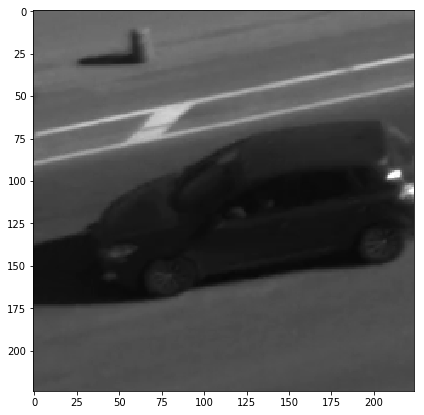

In [55]:
plt.imshow(classes_pict['car'][4])